In [2]:
pip install pandas matplotlib seaborn wordcloud scikit-learn datasets nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



IMDB Data Split:
Train set: 40000 | Test set: 10000


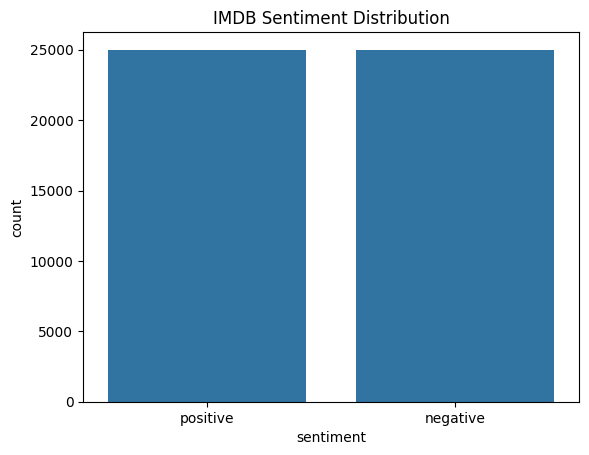

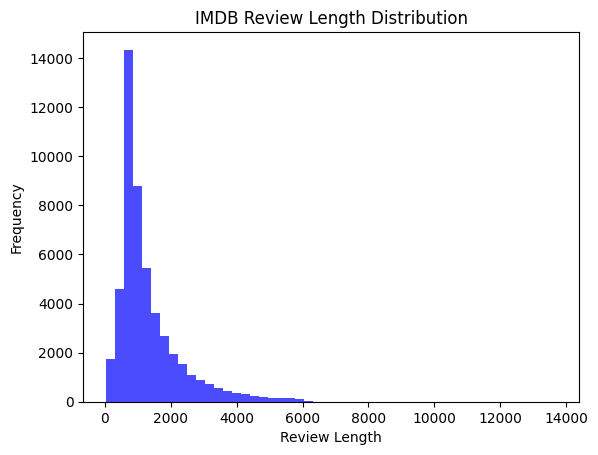


SST2 Data Split:
Train set: 54576 | Test set: 13645


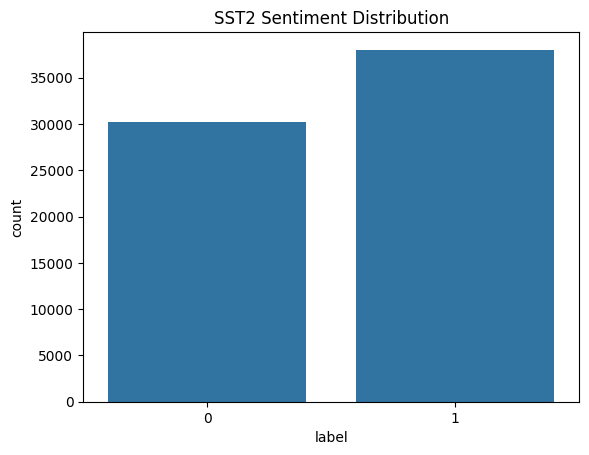

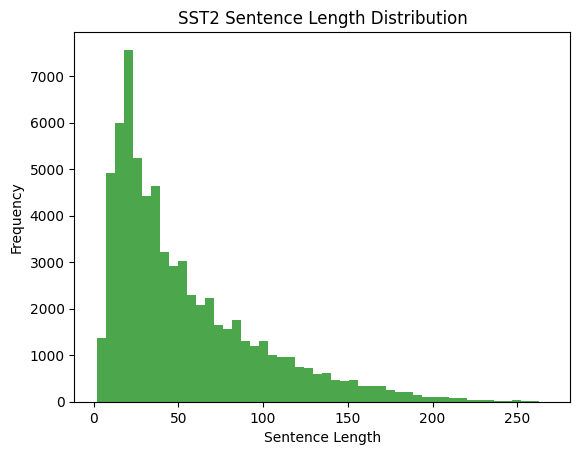

In [ ]:
import os
import pandas as pd
import spacy
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# Load SST-2 dataset
sst2 = load_dataset("glue", "sst2")

# Download stopwords if not already available
nltk.download("stopwords")
nltk.download("wordnet")

# Load NLP tools
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
stop_words = nlp.Defaults.stop_words

"""
def preprocess_text_imdb(text):
    text = text.lower().translate(str.maketrans("", "", string.punctuation))
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()] # Lemmatize and remove non-alphabetic tokens
    return words
def preprocess_text_imdb(text):
    # Fast text preprocessing: lowercasing, punctuation removal, and lemmatization.
    text = text.lower().translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    doc = nlp(text)  # Process text using spaCy
    words = [token.lemma_ for token in doc if token.text.isalpha() and token.text not in stop_words]  # Fast lemmatization
    return words
"""

def preprocess_texts(texts):
    """Fast batch processing with spaCy's nlp.pipe()"""
    texts = [text.lower().translate(str.maketrans("", "", string.punctuation)) for text in texts]
    docs = nlp.pipe(texts)
    return [[token.lemma_ for token in doc if token.is_alpha and token.text not in stop_words] for doc in docs]

# --- Load & Clean IMDB Dataset ---
imdb_file = "IMDB Dataset.csv"
if os.path.exists(imdb_file):
    imdb_df = pd.read_csv(imdb_file)
    imdb_df["tokens"] = preprocess_texts(imdb_df["review"].tolist())

    # Separate positive and negative reviews
    pos_reviews = [word for tokens in imdb_df[imdb_df["sentiment"] == "positive"]["tokens"] for word in tokens]
    neg_reviews = [word for tokens in imdb_df[imdb_df["sentiment"] == "negative"]["tokens"] for word in tokens]

    # Get most common words
    pos_words_freq = Counter(pos_reviews).most_common(20)
    neg_words_freq = Counter(neg_reviews).most_common(20)

    # Extract review length
    imdb_df["review_length"] = imdb_df["review"].str.len()

    # Data Splitting
    X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(
        imdb_df["review"], imdb_df["sentiment"], test_size=0.2, random_state=42
    )

    print(f"\nIMDB Data Split:\nTrain set: {len(X_train_imdb)} | Test set: {len(X_test_imdb)}")

    # EDA: Class distribution
    sns.countplot(x=imdb_df["sentiment"])
    plt.title("IMDB Sentiment Distribution")
    plt.show()

    # EDA: Review Length Distribution
    plt.hist(imdb_df["review_length"], bins=50, color='blue', alpha=0.7)
    plt.title("IMDB Review Length Distribution")
    plt.xlabel("Review Length")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("Error: IMDB Dataset.csv not found.")

# --- Load & Clean SST2 Dataset ---
sst2_train = pd.DataFrame(sst2["train"])
sst2_validation = pd.DataFrame(sst2["validation"])
sst2_df = pd.concat([sst2_train, sst2_validation], ignore_index=True)
sst2_df.rename(columns={"sentence": "sentence", "label": "label"}, inplace=True)

# Apply preprocessing
sst2_df["tokens"] = preprocess_texts(sst2_df["sentence"].tolist())

# Separate positive and negative reviews
pos_reviews_sst2 = [word for tokens in sst2_df[sst2_df["label"] == 1]["tokens"] for word in tokens]
neg_reviews_sst2 = [word for tokens in sst2_df[sst2_df["label"] == 0]["tokens"] for word in tokens]

# Get most common words
pos_words_freq_sst2 = Counter(pos_reviews_sst2).most_common(20)
neg_words_freq_sst2 = Counter(neg_reviews_sst2).most_common(20)

# Extract sentence length
sst2_df["sentence_length"] = sst2_df["sentence"].str.len()

# Data Splitting
X_train_sst2, X_test_sst2, y_train_sst2, y_test_sst2 = train_test_split(
    sst2_df["sentence"], sst2_df["label"], test_size=0.2, random_state=42
)

print(f"\nSST2 Data Split:\nTrain set: {len(X_train_sst2)} | Test set: {len(X_test_sst2)}")

# EDA: Class distribution
sns.countplot(x=sst2_df["label"])
plt.title("SST2 Sentiment Distribution")
plt.show()

# EDA: Sentence Length Distribution
plt.hist(sst2_df["sentence_length"], bins=50, color='green', alpha=0.7)
plt.title("SST2 Sentence Length Distribution")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()
